In [1]:
#Model B 
# CNN with Deeper Architecture and Regularization
# Uses Augmentation for training
# Uses Deeper Model with BatchNorm and Droput and GAP
# Uses Optimizer Weight Decay for Regularization

In [1]:
import os, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
# Paths and Loading Splits
DATA_DIR = r"/Users/allendang/Downloads/natural_images_dataset/natural_images"
SPLIT_FILE = "splits.npz"

IMG_SIZE = 160        # was 224 (too slow on CPU)
BATCH_SIZE = 32

EPOCHS = 18           # start lower on CPU; you can increase later
LR = 1e-3
WEIGHT_DECAY = 1e-4

NUM_WORKERS = 0       # IMPORTANT for Windows/Jupyter
PIN_MEMORY = False    # only useful on CUDA

# Optional: debug speed mode (set to None for full epoch)
MAX_TRAIN_BATCHES = None  # e.g. 100 while debugging


In [3]:
#Load Data Splits
splits = np.load(SPLIT_FILE)
train_idx = splits["train_idx"]
val_idx   = splits["val_idx"]
test_idx  = splits["test_idx"]
print("Loaded split sizes:", len(train_idx), len(val_idx), len(test_idx))


Loaded split sizes: 4829 1034 1036


In [4]:
#Dataset Wrapper
class SubsetWithTransform(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.dataset[self.indices[i]]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

def subset_with_transform(data_dir, indices, transform):
    base = ImageFolder(root=data_dir)  # keep raw PIL images
    return SubsetWithTransform(base, indices, transform=transform)

In [5]:
#Transform
train_tfms_B = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Need class names for report outputs
base_ds_eval = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)
class_names = base_ds_eval.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [6]:
#Subsets and DataLoaders
train_ds = subset_with_transform(DATA_DIR, train_idx, train_tfms_B)
val_ds   = subset_with_transform(DATA_DIR, val_idx, eval_tfms)
test_ds  = subset_with_transform(DATA_DIR, test_idx, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


In [7]:
#Deeper Architecture CNN Model with BatchNorm, Dropout, and Global Average Pooling
class DeeperRegCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.4):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )

        self.b1 = block(3, 32)
        self.b2 = block(32, 64)
        self.b3 = block(64, 128)
        self.b4 = block(128, 256)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.gap(x)
        return self.head(x)

model = DeeperRegCNN(num_classes, dropout=0.4).to(device)

In [8]:
#Training and Evaluation Functions
def run_epoch(model, loader, optimizer=None, max_batches=None):
    is_train = optimizer is not None
    model.train(is_train)
    loss_fn = nn.CrossEntropyLoss()

    total_loss, total_correct, total_n = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = loss_fn(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        logits = model(x.to(device))
        p = logits.argmax(1).cpu().numpy()
        preds.extend(p)
        ys.extend(y.numpy())
    return np.array(ys), np.array(preds)

def plot_history(hist, title):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " - Loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " - Accuracy")
    plt.show()


Epoch 01 | train 0.9049/0.6881 | val 0.9800/0.6625
Epoch 02 | train 0.5725/0.7952 | val 0.6462/0.7689
Epoch 03 | train 0.4581/0.8372 | val 0.4940/0.8250
Epoch 04 | train 0.3908/0.8584 | val 0.5157/0.8346
Epoch 05 | train 0.3898/0.8559 | val 0.3954/0.8549
Epoch 06 | train 0.3720/0.8565 | val 0.4618/0.8462
Epoch 07 | train 0.3353/0.8768 | val 0.3379/0.8694
Epoch 08 | train 0.3003/0.8869 | val 0.4137/0.8540
Epoch 09 | train 0.3002/0.8867 | val 0.2369/0.9178
Epoch 10 | train 0.2756/0.8952 | val 0.5686/0.8143
Epoch 11 | train 0.2667/0.9014 | val 0.2351/0.9178
Epoch 12 | train 0.2429/0.9097 | val 0.3998/0.8569
Epoch 13 | train 0.2344/0.9141 | val 0.2154/0.9294
Epoch 14 | train 0.2266/0.9180 | val 0.3618/0.8801
Epoch 15 | train 0.2111/0.9190 | val 0.3261/0.8878
Epoch 16 | train 0.2224/0.9176 | val 0.2290/0.9130
Epoch 17 | train 0.2209/0.9157 | val 0.2066/0.9168
Epoch 18 | train 0.2077/0.9190 | val 0.2599/0.9081
Early stopping triggered.


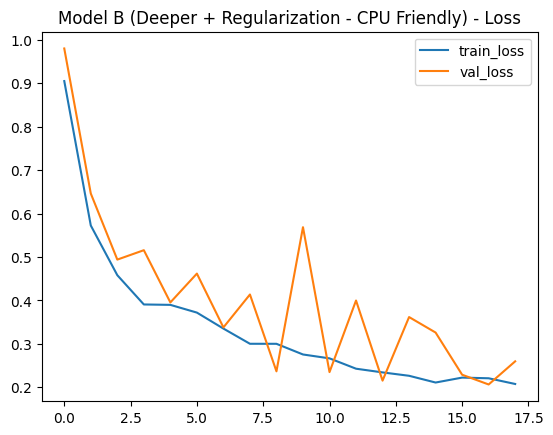

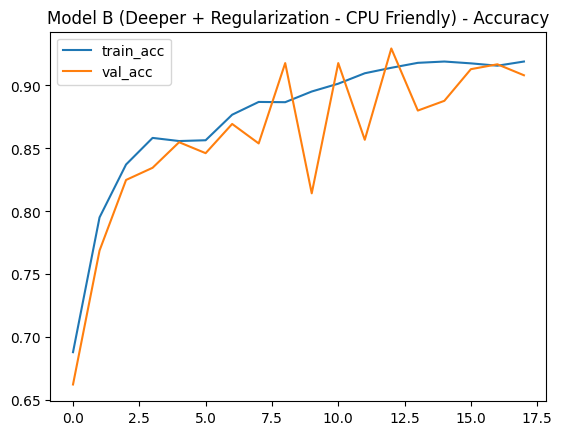

In [ ]:
#Training with Weight Decay
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val = -1
best_state = None
patience = 5
bad_epochs = 0

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer=optimizer, max_batches=MAX_TRAIN_BATCHES)
    va_loss, va_acc = run_epoch(model, val_loader, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1

    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

    if bad_epochs >= patience:
        print("Early stopping triggered.")
        break

model.load_state_dict(best_state)
plot_history(history, "Model B (Deeper + Regularization - CPU Friendly)")


Model B Test Accuracy: 0.9199
Confusion Matrix:
 [[ 88   0   3   1   4   0   4   0]
 [  0 150   0   1   0   0   0   0]
 [  1   0 133  19   2   0   0   1]
 [  1   2  23  73   5   0   0   3]
 [  0   0   0   7 131   0   0   0]
 [  0   0   0   0   2 130   0   1]
 [  0   0   1   0   2   0 121   0]
 [  0   0   0   0   0   0   0 127]]

Classification Report:

              precision    recall  f1-score   support

    airplane       0.98      0.88      0.93       100
         car       0.99      0.99      0.99       151
         cat       0.83      0.85      0.84       156
         dog       0.72      0.68      0.70       107
      flower       0.90      0.95      0.92       138
       fruit       1.00      0.98      0.99       133
   motorbike       0.97      0.98      0.97       124
      person       0.96      1.00      0.98       127

    accuracy                           0.92      1036
   macro avg       0.92      0.91      0.92      1036
weighted avg       0.92      0.92      0.92      

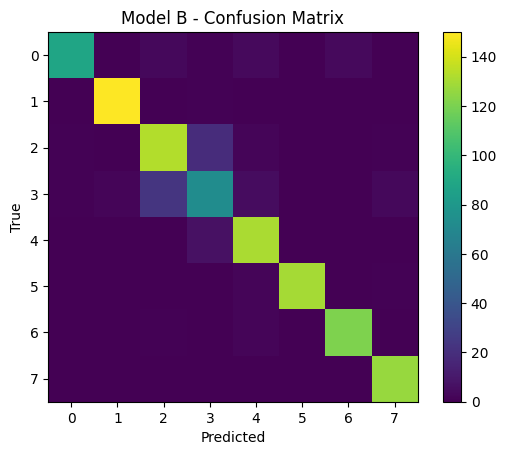

In [10]:
# Test Metrics
y_true, y_pred = predict_all(model, test_loader)
test_acc = (y_true == y_pred).mean()
print("Model B Test Accuracy:", round(float(test_acc), 4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure()
plt.imshow(cm)
plt.title("Model B - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

